- **This code computes the CLDRTO solution using a scenario-based stochastic programming approach**
- Using tracking objective function
- The underlying control structure (modeled in the CLDRTO model) is an MPC, which can is solved using three different strategies: 1. unconstrained, 2. constrained using binaries, and 3. constrained using MPCC
- The problem is posed as a scenario-based stochastic programming problem
- The problem is solved using a monolithic structure, i.e. independently of the number of scenarios or reactors in parallel, everything is solved at once.
- The case study is an affine multiple parallel bioreactor system from:*Gao, Ling. "Modeling and dynamics analyses of immobilized CSTR bioreactor using transfer function model." 2012 International Symposium on Information Technologies in Medicine and Education. Vol. 2. IEEE, 2012.*
- The uncertainty represented by the scenarios comes from the maximum specific growth rate (V_m) --> see matlab file

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: May 2023

In [ ]:
using LinearAlgebra, JuMP, CPLEX, Ipopt, Plots, CSV, DataFrames

# Bioreactor Model

$\dfrac{d C}{d t} = D (C_{in} - C) - \dfrac{V_m C}{(K_s + C)} $ <br>
$ \dfrac{d P}{d t} = \dfrac{V_m C}{(K_s + C)} - DP $ <br>

where, <br>
$t$: time in hours \[h\] <br>
$C$: concentration of reactant (substrate) \[g/L\] <br>
$P$: concentration of product (biomass) \[g/L\] <br>
$C_{in}$: inlet concentration of substrate \[g/L\] <br>
$D$: ratio of flowrate to reactor volume \[1/h\] <br>
$V_m$: maximum reaction rate \[g/(h L)\] <br> 
$K_s$: reaction constant \[g/L\] <br>

- System measurement ($y$) - product concentration $P$ <br>
- System inputs ($u$) - inlet reactant concentration $C_{in}$ <br>
- Uncertain parameters ($\theta$) - maximum reaction rate $V_m$

In [2]:
# Sampling time
T = 1 #[h]
# Simulation time in sampling periods
nsim = 20

# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1

# setting bounds (all arbitrary - not in deviation form!!) 
uMax = 5.0 # for tight constraints: 1.9 | for loose constraints: 5.0
uMin = 0.0;

yspMax = 1.2 
yspMin = 0.0;

# Building CL-DRTO model

## Model linearization
- linearization is done using Matlab's functions ss and c2d (see BioReactorLinearization.m)
- sample time $\Delta t$ is consider as 1h
- linearization around point: $V_m = 0.5$ \[g/(h L)\], $K_s = 0.2$ \[g/L\], $D = 0.5$ \[1/h\], $C_{in,0} = 1$ \[g/L\], $C_{0} = 0.358$ \[g/L\], and $P_{0} = 0.642$ \[g/L\]

which leads to: <br>
$\bar{x}_{k+1} = A \bar{x}_k + B \bar{u}_k$ <br>
$\bar{y}_k = C \bar{u}_k$

where, <br>
$\bar{x} = \begin{bmatrix}
\bar{C}\\
\bar{P}
\end{bmatrix} =
\begin{bmatrix}
C - C_0\\
P - P_0
\end{bmatrix}$<br>
$\bar{u} = \bar{C}_{in} = C_{in} - C_{in,0}$<br>
$\bar{y} = \bar{P} = P - P_0$

In [3]:
# Linearization point
u0 = 1.5
x0 = [0.7179;0.7821]
y0 = 0.7821;

In [4]:
# 100 pre-computed models based on parametric uncertainty Vm (computed using matlab: BioReactorLinearization.m)
bioModels = CSV.read("C:\\Users\\MACC-Jose\\Documents\\GitHub\\BD\\CLDRTO Case Study 2 - Bioreactor\\BioreactorModel", DataFrame; header=false);
#print(bioModels)

CL-DRTO configuration

In [5]:
# DRTO sampling time
nDRTO = 4 # [h]
# Prediction horizon
pD = 20 + (8 - 1) # p = 8 *controller horizon
# Input control horizon 
mD = 20
# Objective function: target tracking (deviation form)
pTrack = 1 - y0 # [g/L]
# Soft upper bounds on P weight (deviation form)
pUB = 1.05 - y0 # [g/L]
# objective function weight for P penalization term 
wP = 100;

DRTO model changes with the number of scenarios and parallel reactors

In [6]:
function DRTO_matrices(nReactors,nScenarios)
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenarios - number of scenarios used in the stochastic optimization
    
    # picking up indexes equally spaced between 1 and 100 (including initial and end point) 
    # based on the desired number of scenarios
    if nScenarios == 1
        indexScen = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenarios-1)) for ii in 1:nScenarios]
    end
    
    # building DRTO model
    A_drto = Array{Float64}(undef,nx,nx,nScenarios) 
    B_drto = Array{Float64}(undef,nx,nu,nScenarios) 

    for kk in 1:nScenarios

        index_temp = indexScen[kk]

        A_drto[:,:,kk] = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
        B_drto[:,:,kk] = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    end

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1], outer = [1, nReactors]);
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

# Building MPC model

Controller configuration

In [7]:
# MPC sampling time
nMPC = 1 # [h]

# Controller configuration
# Output prediction horizon
p = 8
# Input control horizon 
m = 2
# Output weights
q = 1
# Input weights 
r = 1;

Notes:
- Using nominal model(indexScen = 50)
- For the description of how the MPC matrices (with disturbance model) are built, check script: *CLDRTO with unconstrained MPC - uncertain plant test*

In [8]:
function MPC_matrices(nReactors)
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    
    # extracting the matrices from the model array computed previously
    nNom = 50 # nominal model --> index = 50
    
    A = kron(I(nReactors),Matrix(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,1:2])) 
    B = repeat(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,3], outer = [nReactors, 1])
    C = repeat([0 1], outer = [1, nReactors])
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

# CLDRTO Problem

$ \min_{\boldsymbol{y}^{SP}} \quad \Phi^{ECO}(\boldsymbol{x},\boldsymbol{y},\boldsymbol{u}) $ <br>

subjected to: ($k$ represents time and $s$ scenarios) <br>

For each scenario ($s = 1,\ldots,n^{scen}$) <br>
>    System dynamics <br>
>    $\boldsymbol{x}_{k + 1,s} = A\boldsymbol{x}_{k,s} + B_s\boldsymbol{u}_{k,s} $ <br>
>    $\boldsymbol{y}_{k,s} = C\boldsymbol{x}_{k,s}$

>    CL-DRTO control horizon: constraints fixing inputs after horizon ends <br>
>    $\boldsymbol{u}_{k,s} - \boldsymbol{u}_{k - 1,s} = 0, \quad k = m^{DRTO} + 1,\ldots,p^{DRTO}$

>    Product quality target band <br>
>    $\boldsymbol{y}_{k,s} + \boldsymbol{\delta}^p_{k,s} \geq \boldsymbol{y}_{target,lb}$ <br>
>    $\boldsymbol{y}_{k,s} - \boldsymbol{\delta}^m_{k,s} \leq \boldsymbol{y}_{target,ub}$

>    MPC Problem <br>
>    $\boldsymbol{u}_{k,s} = f_{MPC}(\boldsymbol{x}_{k,s},\boldsymbol{y}_{k,s},\boldsymbol{u}_{k-1,s})$       

Non-antecipativity constraints <br>
$\boldsymbol{y}^{SP}_{k,s} = \boldsymbol{y}^{SP}_{k,S}, \quad k = 1,\ldots,\Delta t_{DRTO} \ \quad s = 1,\ldots,S - 1,S + 1,\ldots,n^{scen}$

Variable bounds <br>
$\forall k, \forall s \quad \boldsymbol{x}_{k,s} \in \mathcal{X}, \ \boldsymbol{u}_{k,s} \in \mathcal{U}, \ \boldsymbol{y}_{k,s} \in \mathcal{Y}, \ \boldsymbol{y}^{SP}_{k,s} \in \mathcal{Y}^{SP}$



## Connection between DRTO and MPC layers (inside CLDRTO formulation)

for one scenario:

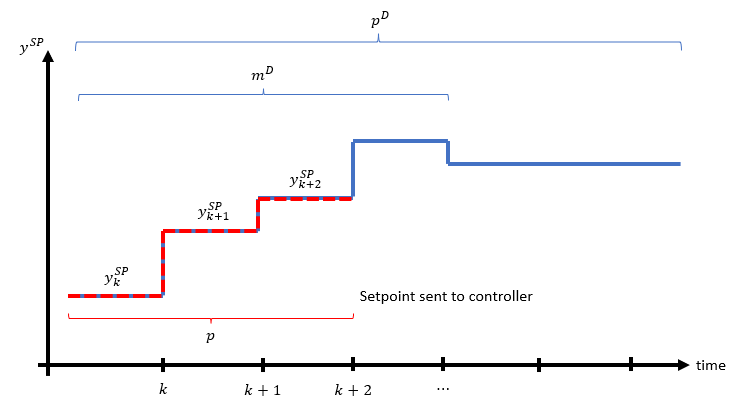

## Nonantecipativity constraints

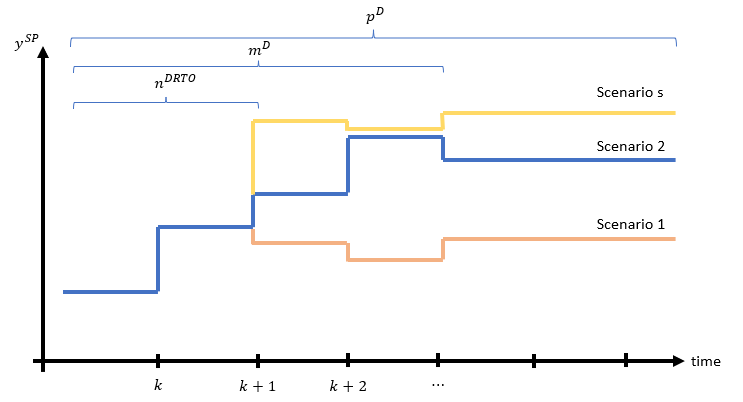

## Soft constraint on y / P

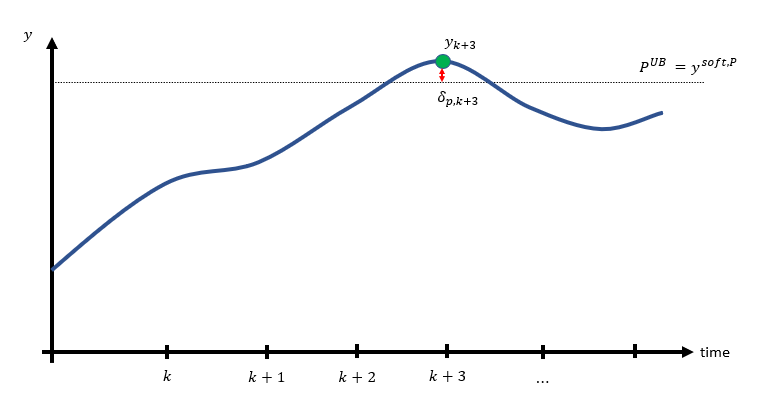

# Solving CL-DRTO Multiscenario Problem (monolithic)

In [9]:
# Parameters for MPC solution
# matrix to compute the gradients of the input bound constraints
conMatrix = [I(m); -I(m)]; 

# big-M implementation
bigM_mu = 1000
bigM_u = 100

# weight complementarity relaxation OF term
pi_bar = 10^3;

In [10]:
## Modeling the sub problem (scenario) -- modeling inside a function
function MS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    drto = DRTO_matrices(nReac,nScen)
    
    # Define model
    if option == 3 || option == 1
        model_ms = Model(Ipopt.Optimizer)
        set_optimizer_attribute(model_ms, "max_cpu_time", 300.0) # 5 min
    else 
        model_ms = Model(CPLEX.Optimizer)
        set_optimizer_attribute(model_ms, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(model_ms)
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_ms, xDRTO[1:pD,1:nx,1:nScen])
    @variable(model_ms, yDRTO[1:pD,1:nScen])
    
    # MPC model variables
    @variable(model_ms, xMPC[1:pD,1:nx,1:nScen])
    @variable(model_ms, yMPC[1:pD,1:nScen])
    
    # MPC <-> DRTO model deviation
    @variable(model_ms, de[1:pD,1:nScen])
    
    # inputs computed by MPCs
    @variable(model_ms, u[1:pD,1:m,1:nScen])
    if option == 1
        @variable(model_ms, u_w_c[1:pD,1:m,1:nScen]) # inputs w/o clipping
    
        # input clipping 
        @variable(model_ms, mu_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, mu_ub[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_ub[1:pD,1:m,1:nScen] ≥ 0)       
    end
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(model_ms, (yspMin - y0) ≤ ysp[1:pD,1:nScen] ≤ (yspMax - y0))
    
    # slacks for P soft constraint
    @variable(model_ms, delta_p[1:pD,1:nScen] ≥ 0)
    
    if option == 2 || option == 3
        @variable(model_ms, mu_g[1:mD,1:(2*m),1:nScen] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(model_ms, Y_lb[1:mD,1:m,1:nScen], Bin, start = 0) # Binaries for big-M implementation
        @variable(model_ms, Y_ub[1:mD,1:m,1:nScen], Bin, start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ss in 1:nScen
            for ii in 1:pD
                set_start_value(yDRTO[ii,ss], solNom['y'][ii,1]) 
                set_start_value(yMPC[ii,ss], solNom['c'][ii,1])
                set_start_value(ysp[ii,ss], solNom['s'][ii,1])

                for rr in 1:nReac # when nReac increases, the number of states change!
                    for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                        set_start_value(xDRTO[ii,xx + (rr - 1)*2,ss], solNom['x'][ii,xx,1])    
                        set_start_value(xMPC[ii,xx + (rr - 1)*2,ss], solNom['m'][ii,xx,1])           
                    end # end xx
                end # number 
                
                for uu in 1:m
                    set_start_value(u[ii,uu,ss], solNom['u'][ii,uu,1])
                end # end of uu
            end # eend of ii
        end # end of ss
    end # end of if
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # Model Dynamic for Dynamic RTO
    @constraint(model_ms, CLDRTO_dyn_model_1[ss=1:nScen], xDRTO[1,:,ss] .== drto['A'][:,:,ss]*xInit + drto['B'][:,:,ss]*uInit)
    @constraint(model_ms, CLDRTO_dyn_model[kk=1:(pD - 1),ss=1:nScen], xDRTO[kk + 1,:,ss] .== drto['A'][:,:,ss]*xDRTO[kk,:,ss] + drto['B'][:,:,ss]*u[kk,1,ss])
    @constraint(model_ms, CLDRTO_model_out[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] == dot(drto['C'],xDRTO[kk,:,ss]))
    
    # fixing setpoint changes after mD
    @constraint(model_ms, control_horizon[kk=(mD+1):pD,ss=1:nScen], u[kk,1,ss] .== u[mD,1,ss])
    
    # P soft constraints
    @constraint(model_ms, soft_P[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] - delta_p[kk,ss] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(model_ms, nonAnt[kk=1:nDRTO,ss=2:nScen], ysp[kk,1] - ysp[kk,ss] == 0.0);
    
    ################
    # MPC solution #
    ################
    if option == 1
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u_w_c[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])
        
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u_w_c[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])
        
        # Unconstrained MPC solution  
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], mpc['H']*u_w_c[1,:,ss] + cfT_1[ss]' .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], mpc['H']*u_w_c[kk,:,ss] + cfT[kk,ss]' .== 0)
        
        # input clipping
        @constraint(model_ms, ic_1[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] == u_w_c[kk,uu,ss] - mu_ub[kk,uu,ss] + mu_lb[kk,uu,ss])
        @constraint(model_ms, ic_2[kk = 1:mD,uu = 1:m,ss = 1:nScen], (uMax - u0) - u[kk,uu,ss] == eta_ub[kk,uu,ss])
        @constraint(model_ms, ic_3[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_ub[kk,uu,ss]*mu_ub[kk,uu,ss] ≤ 1e-6)
        @constraint(model_ms, ic_4[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] - (uMin - u0) == eta_lb[kk,uu,ss])
        @constraint(model_ms, ic_5[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_lb[kk,uu,ss]*mu_lb[kk,uu,ss] ≤ 1e-6)
        
    elseif option == 2
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])
        
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with binaries
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(model_ms, bigM_1[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu,ss] ≤ bigM_mu*Y_ub[kk,uu,ss])
        @constraint(model_ms, bigM_2[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu + m,ss] ≤ bigM_mu*Y_lb[kk,uu,ss])
        @constraint(model_ms, bigM_3[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu,ss]))
        @constraint(model_ms, bigM_4[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≥ -bigM_u*(1 - Y_lb[kk,uu,ss]))
        
        @constraint(model_ms, compSlack[kk=1:mD,uu=1:m,ss=1:nScen], Y_ub[kk,uu,ss] + Y_lb[kk,uu,ss] ≤ 1)
    
    elseif option == 3
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with MPCC
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @expression(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0))
        @expression(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss])
        
        @constraint(model_ms, MPC_c_upper[kk=1:mD,uu=1:m,ss=1:nScen], g_u_u[kk,uu,ss] ≤ 0)
        @constraint(model_ms, MPC_c_lower[kk=1:mD,uu=1:m,ss=1:nScen], g_u_l[kk,uu,ss] ≤ 0)
        
    end
        
    #############################
    # Set up objective function #
    #############################
    if option == 1 || option == 2
        @objective(model_ms, Min, 
            pScen*sum((yDRTO[kk,ss] - pTrack)^2 + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
        )
    else
        @objective(model_ms, Min, pScen*sum((yDRTO[kk,ss] - pTrack)^2 + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
                                - pScen*pi_bar*sum(
                                                sum(mu_g[kk,jj,ss]*g_u_u[kk,jj,ss] for jj = 1:m) +
                                                sum(mu_g[kk,jj + m,ss]*g_u_l[kk,jj,ss] for jj = 1:m)
                                                for kk = 1:mD, ss in 1:nScen)
        )
    end
    # @show model_ms

    #################
    # Solve Problem #
    #################
    optimize!(model_ms)
    
    status = termination_status(model_ms)
    #display(status)
    
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # solution time
        timeSol = solve_time(model_ms)

        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_ms)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)

        outputFun = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray)
        
        if option == 2 || option == 3
            muArray = value.(mu_g)
            merge!(outputFun,Dict('μ'=> muArray))
        end
        
        return outputFun
    else
        # Handle other cases.
        flag = 0
        
        return flag
    end
end;

Computing nominal solution

In [11]:
#number of scenarios 
scenNom = 1
#equiprobable scenarios
pNom = 1.0
#number of reactors 
reacNom = 1
# number of states of the nominal solution
nx = 2*reacNom
# MPC solution option
optNom = 1 # unconstrained

solNominal = MS_CLDRTO(x0,u0,reacNom,scenNom,pNom,0,optNom);

# Checking the performance of the methods in terms of time vs. nScen

In [12]:
nScenTotal = 50 # 15 | 50

# preparing plot --> strategy for solving MPC
solTimeTraj_s = Matrix{Float64}(undef,3,nScenTotal) 

# number of reactors in parallel
nReactors = 1
# Number of states
nx = 2*nReactors

# Initial conditions (deviation form)
xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nReactors,1]);
uInit_0 = 1.0 - u0;

for opti in 1:3
    #option = 1 # : Unconstrained MPC
    #option = 2 # : Constrained MPC with binaries
    #option = 3 # : Constrained MPC with MPCC

    for ss in 1:nScenTotal
        display("evaluation $(ss) scenarios | option $(opti)")
        
        #number os scenarios
        nScen = ss
        #equiprobable scenarios
        pScen = 1.0/nScen;
        
        # solving monolithical problem 
        sol_m_Dict = MS_CLDRTO(xInit_0,uInit_0,nReactors,nScen,pScen,solNominal,opti)
        
        # saving values for plotting if problem was solved
        # output being a dictionary controls if the solver has converged or not 
        if sol_m_Dict isa Dict
            solTimeTraj_s[opti,ss] = sol_m_Dict['t']
        else
            solTimeTraj_s[opti,ss] = NaN
        end
        
    end
end


"simulation iteration: 1 | option 1"

"simulation iteration: 2 | option 1"

"simulation iteration: 3 | option 1"

"simulation iteration: 4 | option 1"

"simulation iteration: 5 | option 1"

"simulation iteration: 6 | option 1"

"simulation iteration: 7 | option 1"

"simulation iteration: 8 | option 1"

"simulation iteration: 9 | option 1"

"simulation iteration: 10 | option 1"

"simulation iteration: 11 | option 1"

"simulation iteration: 12 | option 1"

"simulation iteration: 13 | option 1"

"simulation iteration: 14 | option 1"

"simulation iteration: 15 | option 1"

"simulation iteration: 16 | option 1"

"simulation iteration: 17 | option 1"

"simulation iteration: 18 | option 1"

"simulation iteration: 19 | option 1"

"simulation iteration: 20 | option 1"

"simulation iteration: 21 | option 1"

"simulation iteration: 22 | option 1"

"simulation iteration: 23 | option 1"

"simulation iteration: 24 | option 1"

"simulation iteration: 25 | option 1"

"simulation iteration: 26 | option 1"

"simulation iteration: 27 | option 1"

"simulation iteration: 28 | option 1"

"simulation iteration: 29 | option 1"

"simulation iteration: 30 | option 1"

"simulation iteration: 31 | option 1"

"simulation iteration: 32 | option 1"

"simulation iteration: 33 | option 1"

"simulation iteration: 34 | option 1"

"simulation iteration: 35 | option 1"

"simulation iteration: 36 | option 1"

"simulation iteration: 37 | option 1"

"simulation iteration: 38 | option 1"

"simulation iteration: 39 | option 1"

"simulation iteration: 40 | option 1"

"simulation iteration: 41 | option 1"

"simulation iteration: 42 | option 1"

"simulation iteration: 43 | option 1"

"simulation iteration: 44 | option 1"

"simulation iteration: 45 | option 1"

"simulation iteration: 46 | option 1"

"simulation iteration: 47 | option 1"

"simulation iteration: 48 | option 1"

"simulation iteration: 49 | option 1"

"simulation iteration: 50 | option 1"

"simulation iteration: 1 | option 2"

"simulation iteration: 2 | option 2"

"simulation iteration: 3 | option 2"

"simulation iteration: 4 | option 2"

"simulation iteration: 5 | option 2"

"simulation iteration: 6 | option 2"

"simulation iteration: 7 | option 2"

"simulation iteration: 8 | option 2"

"simulation iteration: 9 | option 2"

"simulation iteration: 10 | option 2"

"simulation iteration: 11 | option 2"

"simulation iteration: 12 | option 2"

"simulation iteration: 13 | option 2"

"simulation iteration: 14 | option 2"

"simulation iteration: 15 | option 2"

"simulation iteration: 16 | option 2"

"simulation iteration: 17 | option 2"

"simulation iteration: 18 | option 2"

"simulation iteration: 19 | option 2"

"simulation iteration: 20 | option 2"

"simulation iteration: 21 | option 2"

"simulation iteration: 22 | option 2"

"simulation iteration: 23 | option 2"

"simulation iteration: 24 | option 2"

"simulation iteration: 25 | option 2"

"simulation iteration: 26 | option 2"

"simulation iteration: 27 | option 2"

"simulation iteration: 28 | option 2"

"simulation iteration: 29 | option 2"

"simulation iteration: 30 | option 2"

"simulation iteration: 31 | option 2"

"simulation iteration: 32 | option 2"

"simulation iteration: 33 | option 2"

"simulation iteration: 34 | option 2"

"simulation iteration: 35 | option 2"

"simulation iteration: 36 | option 2"

"simulation iteration: 37 | option 2"

"simulation iteration: 38 | option 2"

"simulation iteration: 39 | option 2"

"simulation iteration: 40 | option 2"

"simulation iteration: 41 | option 2"

"simulation iteration: 42 | option 2"

"simulation iteration: 43 | option 2"

"simulation iteration: 44 | option 2"

"simulation iteration: 45 | option 2"

"simulation iteration: 46 | option 2"

"simulation iteration: 47 | option 2"

"simulation iteration: 48 | option 2"

"simulation iteration: 49 | option 2"

"simulation iteration: 50 | option 2"

"simulation iteration: 1 | option 3"


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



"simulation iteration: 2 | option 3"

"simulation iteration: 3 | option 3"

"simulation iteration: 4 | option 3"

"simulation iteration: 5 | option 3"

"simulation iteration: 6 | option 3"

"simulation iteration: 7 | option 3"

"simulation iteration: 8 | option 3"

"simulation iteration: 9 | option 3"

"simulation iteration: 10 | option 3"

"simulation iteration: 11 | option 3"

"simulation iteration: 12 | option 3"

"simulation iteration: 13 | option 3"

"simulation iteration: 14 | option 3"

"simulation iteration: 15 | option 3"

"simulation iteration: 16 | option 3"

"simulation iteration: 17 | option 3"

"simulation iteration: 18 | option 3"

"simulation iteration: 19 | option 3"

"simulation iteration: 20 | option 3"

"simulation iteration: 21 | option 3"

"simulation iteration: 22 | option 3"

"simulation iteration: 23 | option 3"

"simulation iteration: 24 | option 3"

"simulation iteration: 25 | option 3"

"simulation iteration: 26 | option 3"

"simulation iteration: 27 | option 3"

"simulation iteration: 28 | option 3"

"simulation iteration: 29 | option 3"

"simulation iteration: 30 | option 3"

"simulation iteration: 31 | option 3"

"simulation iteration: 32 | option 3"

"simulation iteration: 33 | option 3"

"simulation iteration: 34 | option 3"

"simulation iteration: 35 | option 3"

"simulation iteration: 36 | option 3"

"simulation iteration: 37 | option 3"

"simulation iteration: 38 | option 3"

"simulation iteration: 39 | option 3"

"simulation iteration: 40 | option 3"

"simulation iteration: 41 | option 3"

"simulation iteration: 42 | option 3"

"simulation iteration: 43 | option 3"

"simulation iteration: 44 | option 3"

"simulation iteration: 45 | option 3"

"simulation iteration: 46 | option 3"

"simulation iteration: 47 | option 3"

"simulation iteration: 48 | option 3"

"simulation iteration: 49 | option 3"

"simulation iteration: 50 | option 3"

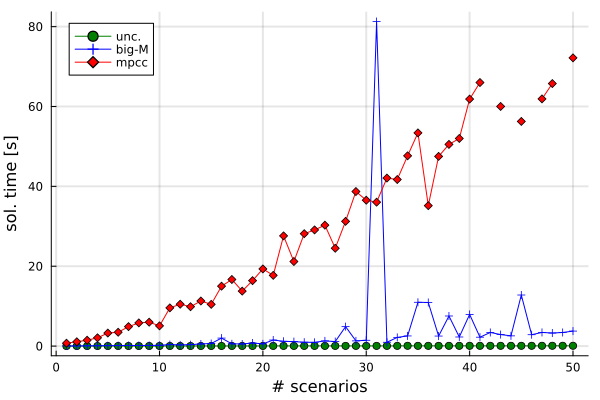

In [13]:
gr()

p1 = plot(xlabel="# scenarios", ylabel="sol. time [s]",gridlinewidth=2)
p1 = plot!(1:nScenTotal,solTimeTraj_s[1,:], linecolor=:green, marker=:circle, markercolor = :green)
p1 = plot!(1:nScenTotal,solTimeTraj_s[2,:], linecolor=:blue, marker=:cross, markercolor = :blue)
p1 = plot!(1:nScenTotal,solTimeTraj_s[3,:], linecolor=:red, marker=:diamond, markercolor = :red)
p1.series_list[1][:label] = "unc."
p1.series_list[2][:label] = "big-M"
p1.series_list[3][:label] = "mpcc"

display(p1)

# Checking the performance of the methods in terms of time vs. nReac

In [14]:
nReactTotal = 50 # 15 | 50

# preparing plot 
solTimeTraj_r = Matrix{Float64}(undef,3,nReactTotal) 

#option = 1 # : Unconstrained MPC
#option = 2 # : Constrained MPC with binaries
#option = 3 # : Constrained MPC with MPCC

# number of reactors in parallel
nScenarios = 1
#equiprobable scenarios
pScenarios = 1.0/nScenarios;

for opti in 1:3
    # dummy for initialization
    sol_m_Dict = 0;
    
    for rr in 1:nScenTotal
        display("simulation iteration: $(rr) | option $(opti)")
        
        #number os reactors
        nReac = rr
        # Number of states
        nx = 2*nReac;

        # Initial conditions (deviation form)
        xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nReac,1]);
        uInit_0 = 1.0 - u0;
        
        # solving monolithical problem 
        sol_m_Dict = MS_CLDRTO(xInit_0,uInit_0,nReac,nScenarios,pScenarios,solNominal,opti)

        # saving values for plotting if problem was solved
        # output being a dictionary controls if the solver has converged or not 
        if sol_m_Dict isa Dict
            solTimeTraj_r[opti,rr] = sol_m_Dict['t']
        else
            solTimeTraj_r[opti,rr] = NaN
        end
        
    end
end


"simulation iteration: 1 | option 1"

"simulation iteration: 2 | option 1"

"simulation iteration: 3 | option 1"

"simulation iteration: 4 | option 1"

"simulation iteration: 5 | option 1"

"simulation iteration: 6 | option 1"

"simulation iteration: 7 | option 1"

"simulation iteration: 8 | option 1"

"simulation iteration: 9 | option 1"

"simulation iteration: 10 | option 1"

"simulation iteration: 11 | option 1"

"simulation iteration: 12 | option 1"

"simulation iteration: 13 | option 1"

"simulation iteration: 14 | option 1"

"simulation iteration: 15 | option 1"

"simulation iteration: 16 | option 1"

"simulation iteration: 17 | option 1"

"simulation iteration: 18 | option 1"

"simulation iteration: 19 | option 1"

"simulation iteration: 20 | option 1"

"simulation iteration: 21 | option 1"

"simulation iteration: 22 | option 1"

"simulation iteration: 23 | option 1"

"simulation iteration: 24 | option 1"

"simulation iteration: 25 | option 1"

"simulation iteration: 26 | option 1"

"simulation iteration: 27 | option 1"

"simulation iteration: 28 | option 1"

"simulation iteration: 29 | option 1"

"simulation iteration: 30 | option 1"

"simulation iteration: 31 | option 1"

"simulation iteration: 32 | option 1"

"simulation iteration: 33 | option 1"

"simulation iteration: 34 | option 1"

"simulation iteration: 35 | option 1"

"simulation iteration: 36 | option 1"

"simulation iteration: 37 | option 1"

"simulation iteration: 38 | option 1"

"simulation iteration: 39 | option 1"

"simulation iteration: 40 | option 1"

"simulation iteration: 41 | option 1"

"simulation iteration: 42 | option 1"

"simulation iteration: 43 | option 1"

"simulation iteration: 44 | option 1"

"simulation iteration: 45 | option 1"

"simulation iteration: 46 | option 1"

"simulation iteration: 47 | option 1"

"simulation iteration: 48 | option 1"

"simulation iteration: 49 | option 1"

"simulation iteration: 50 | option 1"

"simulation iteration: 1 | option 2"

"simulation iteration: 2 | option 2"

"simulation iteration: 3 | option 2"

"simulation iteration: 4 | option 2"

"simulation iteration: 5 | option 2"

"simulation iteration: 6 | option 2"

"simulation iteration: 7 | option 2"

"simulation iteration: 8 | option 2"

"simulation iteration: 9 | option 2"

"simulation iteration: 10 | option 2"

"simulation iteration: 11 | option 2"

"simulation iteration: 12 | option 2"

"simulation iteration: 13 | option 2"

"simulation iteration: 14 | option 2"

"simulation iteration: 15 | option 2"

"simulation iteration: 16 | option 2"

"simulation iteration: 17 | option 2"

"simulation iteration: 18 | option 2"

"simulation iteration: 19 | option 2"

"simulation iteration: 20 | option 2"

"simulation iteration: 21 | option 2"

"simulation iteration: 22 | option 2"

"simulation iteration: 23 | option 2"

"simulation iteration: 24 | option 2"

"simulation iteration: 25 | option 2"

"simulation iteration: 26 | option 2"

"simulation iteration: 27 | option 2"

"simulation iteration: 28 | option 2"

"simulation iteration: 29 | option 2"

"simulation iteration: 30 | option 2"

"simulation iteration: 31 | option 2"

"simulation iteration: 32 | option 2"

"simulation iteration: 33 | option 2"

"simulation iteration: 34 | option 2"

"simulation iteration: 35 | option 2"

"simulation iteration: 36 | option 2"

"simulation iteration: 37 | option 2"

"simulation iteration: 38 | option 2"

"simulation iteration: 39 | option 2"

"simulation iteration: 40 | option 2"

"simulation iteration: 41 | option 2"

"simulation iteration: 42 | option 2"

"simulation iteration: 43 | option 2"

"simulation iteration: 44 | option 2"

"simulation iteration: 45 | option 2"

"simulation iteration: 46 | option 2"

"simulation iteration: 47 | option 2"

"simulation iteration: 48 | option 2"

"simulation iteration: 49 | option 2"

"simulation iteration: 50 | option 2"

"simulation iteration: 1 | option 3"

"simulation iteration: 2 | option 3"

"simulation iteration: 3 | option 3"

"simulation iteration: 4 | option 3"

"simulation iteration: 5 | option 3"

"simulation iteration: 6 | option 3"

"simulation iteration: 7 | option 3"

"simulation iteration: 8 | option 3"

"simulation iteration: 9 | option 3"

"simulation iteration: 10 | option 3"

"simulation iteration: 11 | option 3"

"simulation iteration: 12 | option 3"

"simulation iteration: 13 | option 3"

"simulation iteration: 14 | option 3"

"simulation iteration: 15 | option 3"

"simulation iteration: 16 | option 3"

"simulation iteration: 17 | option 3"

"simulation iteration: 18 | option 3"

"simulation iteration: 19 | option 3"

"simulation iteration: 20 | option 3"

"simulation iteration: 21 | option 3"

"simulation iteration: 22 | option 3"

"simulation iteration: 23 | option 3"

"simulation iteration: 24 | option 3"

"simulation iteration: 25 | option 3"

"simulation iteration: 26 | option 3"

"simulation iteration: 27 | option 3"

"simulation iteration: 28 | option 3"

"simulation iteration: 29 | option 3"

"simulation iteration: 30 | option 3"

"simulation iteration: 31 | option 3"

"simulation iteration: 32 | option 3"

"simulation iteration: 33 | option 3"

"simulation iteration: 34 | option 3"

"simulation iteration: 35 | option 3"

"simulation iteration: 36 | option 3"

"simulation iteration: 37 | option 3"

"simulation iteration: 38 | option 3"

"simulation iteration: 39 | option 3"

"simulation iteration: 40 | option 3"

"simulation iteration: 41 | option 3"

"simulation iteration: 42 | option 3"

"simulation iteration: 43 | option 3"

"simulation iteration: 44 | option 3"

"simulation iteration: 45 | option 3"

"simulation iteration: 46 | option 3"

"simulation iteration: 47 | option 3"

"simulation iteration: 48 | option 3"

"simulation iteration: 49 | option 3"

"simulation iteration: 50 | option 3"

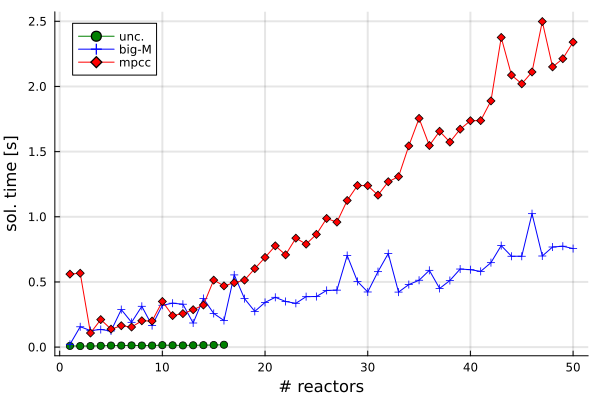

In [15]:
gr()

p2 = plot(xlabel="# reactors", ylabel="sol. time [s]",gridlinewidth=2)
p2 = plot!(1:nScenTotal,solTimeTraj_r[1,:], linecolor=:green, marker=:circle, markercolor = :green)
p2 = plot!(1:nScenTotal,solTimeTraj_r[2,:], linecolor=:blue, marker=:cross, markercolor = :blue)
p2 = plot!(1:nScenTotal,solTimeTraj_r[3,:], linecolor=:red, marker=:diamond, markercolor = :red)
p2.series_list[1][:label] = "unc."
p2.series_list[2][:label] = "big-M"
p2.series_list[3][:label] = "mpcc"

display(p2)

# Checking if trajectories match for more scenarios and reactors
- arbitrarily chosen number of scenarios and reactors

In [16]:
nSCheck = 3 # number of scenarios
nRCheck = 3 # number of reactors in parallel

# Extracting solution for plotting
yTraj = Array{Float64}(undef,3,pD,nSCheck)
uTraj = Array{Float64}(undef,3,pD,nSCheck) 
yspTraj = Array{Float64}(undef,3,pD,nSCheck) 

#equiprobable scenarios
pScheck = 1.0/nSCheck;

# Number of states
nx = 2*nRCheck;

# Initial conditions (deviation form)
xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nRCheck,1]);
uInit_0 = 1.0 - u0;

for opti in 1:3
    sol_dict = MS_CLDRTO(xInit_0,uInit_0,nRCheck,nSCheck,pScheck,solNominal,opti)
    #display(sol_dict['f'])
    for ii in 1:pD
        for ss in 1:nSCheck
            # transforming from deviation form
            yTraj[opti,ii,ss] = sol_dict['y'][ii,ss] + y0
            yspTraj[opti,ii,ss] = sol_dict['s'][ii,ss] + y0
            uTraj[opti,ii,ss] = sol_dict['u'][ii,1,ss] + u0
        end
    end
end;

In [17]:
# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

# Creating color array
CList = reshape( range(colorant"red", stop=colorant"blue",length=nSCheck), 1, nSCheck);
#display(CList)
MList =[:cross, :circle, :diamond];

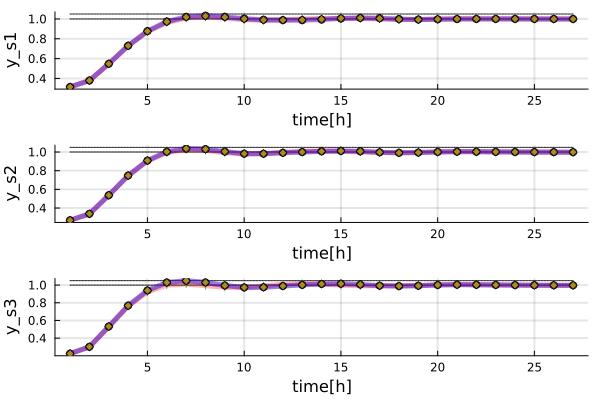

In [18]:
gr()
###########
# OUTPUTS #
###########
# limits
p3 = plot(ts,(pUB + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="y_s1",legend=false,gridlinewidth=2)
p3 = plot!(ts,(pTrack + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black,legend=false)

for opti in 1:3
    p3 = plot!(ts,yTraj[opti,:,1],linewidth=5,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

p4 = plot(ts,(pUB + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="y_s2",legend=false,gridlinewidth=2)
p4 = plot!(ts,(pTrack + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black,legend=false)

for opti in 1:3
    p4 = plot!(ts,yTraj[opti,:,2],linewidth=5,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

p5 = plot(ts,(pUB + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="y_s3",legend=false,gridlinewidth=2)
p5 = plot!(ts,(pTrack + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black,legend=false)

for opti in 1:3
    p5 = plot!(ts,yTraj[opti,:,3],linewidth=5,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

g1 = plot(p3,p4,p5,layout=(3,1))
display(g1)

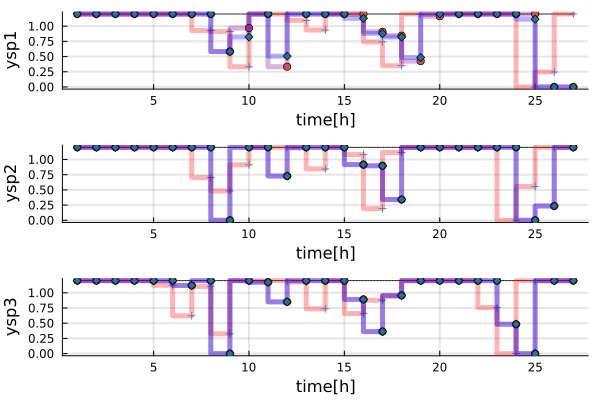

In [19]:
#############
# SETPOINTS #
#############
# limits
p6 = plot(ts,yspMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="ysp1",legend=false,gridlinewidth=2)
for opti in 1:3
    p6 = plot!(ts,yspTraj[opti,:,1],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

p7 = plot(ts,yspMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="ysp2",legend=false,gridlinewidth=2)
for opti in 1:3
    p7 = plot!(ts,yspTraj[opti,:,2],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

p8 = plot(ts,yspMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="ysp3",legend=false,gridlinewidth=2)
for opti in 1:3
    p8 = plot!(ts,yspTraj[opti,:,3],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

g2 = plot(p6,p7,p8,layout=(3,1))
display(g2)

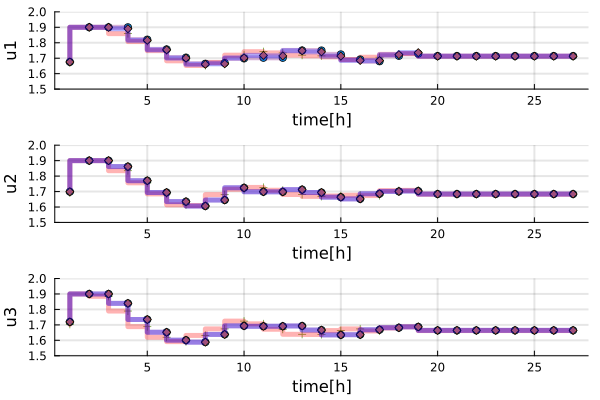

In [20]:
##########
# INPUTS #
##########
# limits
#p9 = plot(ts,uMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="u1",legend=false,gridlinewidth=2,ylims = (1.5,2.0),yticks = 1.5:0.1:2.0)
p9 = plot(xaxis="time[h]",yaxis="u1",gridlinewidth=2,ylims = (1.5,2.0),yticks = 1.5:0.1:2.0)

for opti in 1:3
    p9 = plot!(ts,uTraj[opti,:,1],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

#p10 = plot(ts,uMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="u2",legend=false,gridlinewidth=2,ylims = (1.5,2.0),yticks = 1.5:0.1:2.0)
p10 = plot(xaxis="time[h]",yaxis="u2",gridlinewidth=2,ylims = (1.5,2.0),yticks = 1.5:0.1:2.0)
for opti in 1:3
    p10 = plot!(ts,uTraj[opti,:,2],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

#p11 = plot(ts,uMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="u3",legend=false,gridlinewidth=2,ylims = (1.5,2.0),yticks = 1.5:0.1:2.0)
p11 = plot(xaxis="time[h]",yaxis="u3",gridlinewidth=2,ylims = (1.5,2.0),yticks = 1.5:0.1:2.0)
for opti in 1:3
    p11 = plot!(ts,uTraj[opti,:,3],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

g3 = plot(p9,p10,p11,layout=(3,1))
display(g3)